In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.426013102412536473840491086280519425818/1-223.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780/2-089.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.16568542011655175430071162144126831780/1-111.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/1-051.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.116437756113164247142539498550746659420/2-203.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.265953197912973660327069359641506533925/1-288.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.295670217913556255928452747763741622478/1-213.jpg
/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.

In [2]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from keras.regularizers import l2
from tensorflow.keras.applications import InceptionV3
import cv2
from skimage.filters import threshold_otsu
from skimage.restoration import wiener
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from skimage.restoration import wiener
from skimage.morphology import disk
import pywt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_meta= pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv')
df_meta.head()

SeriesInstanceUID  \
0  1.3.6.1.4.1.9590.100.1.2.117041576511324414842...   
1  1.3.6.1.4.1.9590.100.1.2.438738396107617880132...   
2  1.3.6.1.4.1.9590.100.1.2.767416741131676463382...   
3  1.3.6.1.4.1.9590.100.1.2.296931352612305599800...   
4  1.3.6.1.4.1.9590.100.1.2.436657670120353100077...   

                                    StudyInstanceUID Modality  \
0  1.3.6.1.4.1.9590.100.1.2.229361142710768138411...       MG   
1  1.3.6.1.4.1.9590.100.1.2.195593486612988388325...       MG   
2  1.3.6.1.4.1.9590.100.1.2.257901172612530623323...       MG   
3  1.3.6.1.4.1.9590.100.1.2.109468616710242115222...       MG   
4  1.3.6.1.4.1.9590.100.1.2.380627129513562450304...       MG   

  SeriesDescription BodyPartExamined  SeriesNumber Collection  Visibility  \
0   ROI mask images           BREAST             1  CBIS-DDSM           1   
1   ROI mask images           BREAST             1  CBIS-DDSM           1   
2   ROI mask images           BREAST             1  CBIS-DDSM           1   
3   ROI mask images           BREAST             1  CBIS-DDSM           1   
4   ROI mask images           BREAST             1  CBIS-DDSM           1   

   ImageCount  
0           2  
1           2  
2           2  
3           2  
4           2

In [4]:
df_dicom = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
df_dicom.head()

file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...   
2  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...   
3  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   
4  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   

                                          image_path  AccessionNumber  \
0  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...              NaN   
1  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...              NaN   
2  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...              NaN   
3  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   
4  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   

   BitsAllocated  BitsStored BodyPartExamined  Columns  ContentDate  \
0             16          16           BREAST      351     20160426   
1             16          16           BREAST     3526     20160426   
2             16          16           BREAST     1546     20160503   
3             16          16           BREAST       97     20160503   
4              8           8      Left Breast     3104     20160503   

   ContentTime ConversionType  ...  \
0   131732.685            WSD  ...   
1   143829.101            WSD  ...   
2   111956.298            WSD  ...   
3   115347.770            WSD  ...   
4   115347.770            WSD  ...   

   SecondaryCaptureDeviceManufacturerModelName      SeriesDescription  \
0                                       MATLAB         cropped images   
1                                       MATLAB  full mammogram images   
2                                       MATLAB  full mammogram images   
3                                       MATLAB         cropped images   
4                                       MATLAB                    NaN   

                                   SeriesInstanceUID SeriesNumber  \
0  1.3.6.1.4.1.9590.100.1.2.129308726812851964007...            1   
1  1.3.6.1.4.1.9590.100.1.2.248386742010678582309...            1   
2  1.3.6.1.4.1.9590.100.1.2.267213171011171858918...            1   
3  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   
4  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   

  SmallestImagePixelValue  SpecificCharacterSet   StudyDate StudyID  \
0                   23078            ISO_IR 100  20160720.0    DDSM   
1                       0            ISO_IR 100  20160720.0    DDSM   
2                       0            ISO_IR 100  20160807.0    DDSM   
3                   32298            ISO_IR 100  20170829.0    DDSM   
4                       0            ISO_IR 100         NaN    DDSM   

                                    StudyInstanceUID  StudyTime  
0  1.3.6.1.4.1.9590.100.1.2.271867287611061855725...   214951.0  
1  1.3.6.1.4.1.9590.100.1.2.161516517311681906612...   193426.0  
2  1.3.6.1.4.1.9590.100.1.2.291043622711253836701...   161814.0  
3  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...   180109.0  
4  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...        NaN  

[5 rows x 38 columns]

In [5]:
df_dicom.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [6]:
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
cropped_images.head(5)

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [7]:
full_mammo = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
full_mammo.head()


1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [8]:
roi_img = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path
roi_img.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [9]:
# Check if row 8027 exists in roi_img
if 8027 in roi_img.index:
    print("Row 8027 exists in roi_img.")
else:
    print("Row 8027 does not exist in roi_img.")


Row 8027 exists in roi_img.


In [10]:
imdir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [11]:
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', imdir, regex=True)
full_mammo = full_mammo.replace('CBIS-DDSM/jpeg', imdir, regex=True)
roi_img = roi_img.replace('CBIS-DDSM/jpeg', imdir, regex=True)

# view new paths
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammo.iloc[0])
print('ROI Mask Images paths:\n')
print(roi_img.iloc[0])

Cropped Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [12]:
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammo:
    key = dicom.split("/")[4]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[4]
    cropped_images_dict[key] = dicom
for dicom in roi_img:
    key = dicom.split("/")[4]
    roi_img_dict[key] = dicom

# view keys
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [13]:
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

mass_train.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image file path  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3  Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   

                             cropped image file path  \
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   

                                  ROI mask file path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....

In [14]:
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
        img_name = img[13].split("/")[2]
        data.iloc[index,13] = roi_img_dict[img_name]
        
# apply to datasets
fix_image_path(mass_train)
fix_image_path(mass_test)
#"C:\Users\91738\Downloads\3rdyear-1stsem\EDI\DDMA\jpeg\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\2-249.jpg"

In [15]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head(5)

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                             cropped_image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                                  ROI_mask_file_path  
0  ../input/cbis-ddsm-breast-cancer-image-dataset...  
1  ../input/cbis-ddsm-breast-cancer-image-dataset...  
2  ../input/cbis-ddsm-breast-cancer-image-dataset...  
3  ../input/cbis-ddsm-breast-cancer-image-dataset...  
4  ../input/cbis-ddsm-breast-cancer-image-dataset...

In [16]:
mass_train['mass_shape'] = mass_train['mass_shape'].bfill()
mass_train['mass_margins'] = mass_train['mass_margins'].bfill()

#check null values
mass_train.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [17]:
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [18]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [19]:
mass_test['mass_margins'] = mass_test['mass_margins'].bfill()

#check null values
mass_test.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [21]:
print(mass_train['cropped_image_file_path'].head())

0    ../input/cbis-ddsm-breast-cancer-image-dataset...
1    ../input/cbis-ddsm-breast-cancer-image-dataset...
2    ../input/cbis-ddsm-breast-cancer-image-dataset...
3    ../input/cbis-ddsm-breast-cancer-image-dataset...
4    ../input/cbis-ddsm-breast-cancer-image-dataset...
Name: cropped_image_file_path, dtype: object


In [22]:
print(mass_train['ROI_mask_file_path'].head())

0    ../input/cbis-ddsm-breast-cancer-image-dataset...
1    ../input/cbis-ddsm-breast-cancer-image-dataset...
2    ../input/cbis-ddsm-breast-cancer-image-dataset...
3    ../input/cbis-ddsm-breast-cancer-image-dataset...
4    ../input/cbis-ddsm-breast-cancer-image-dataset...
Name: ROI_mask_file_path, dtype: object


Full Mammograms:



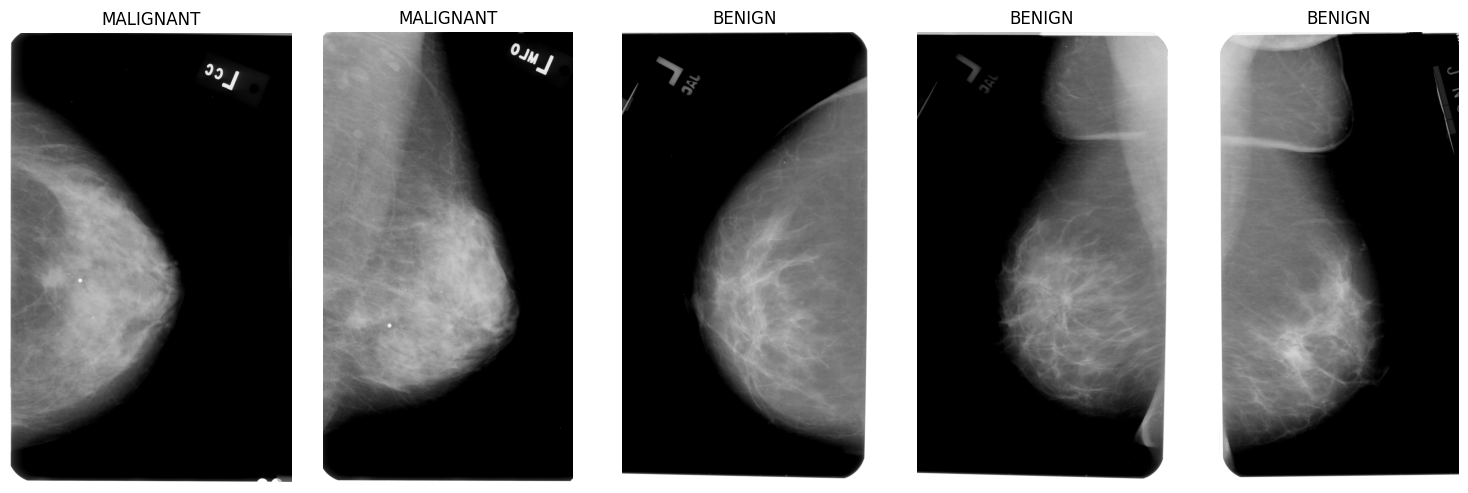

Cropped Mammograms:



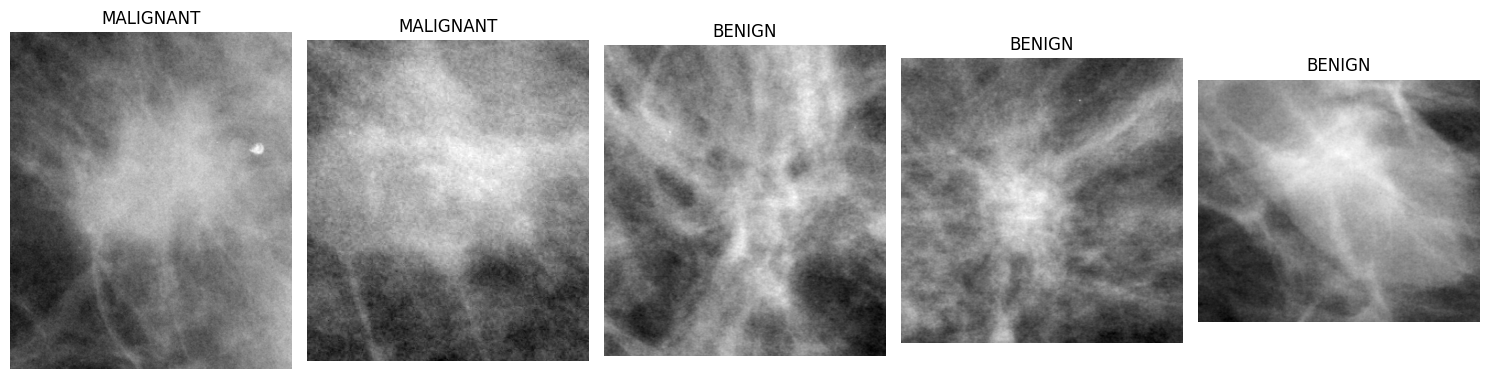

ROI mask:



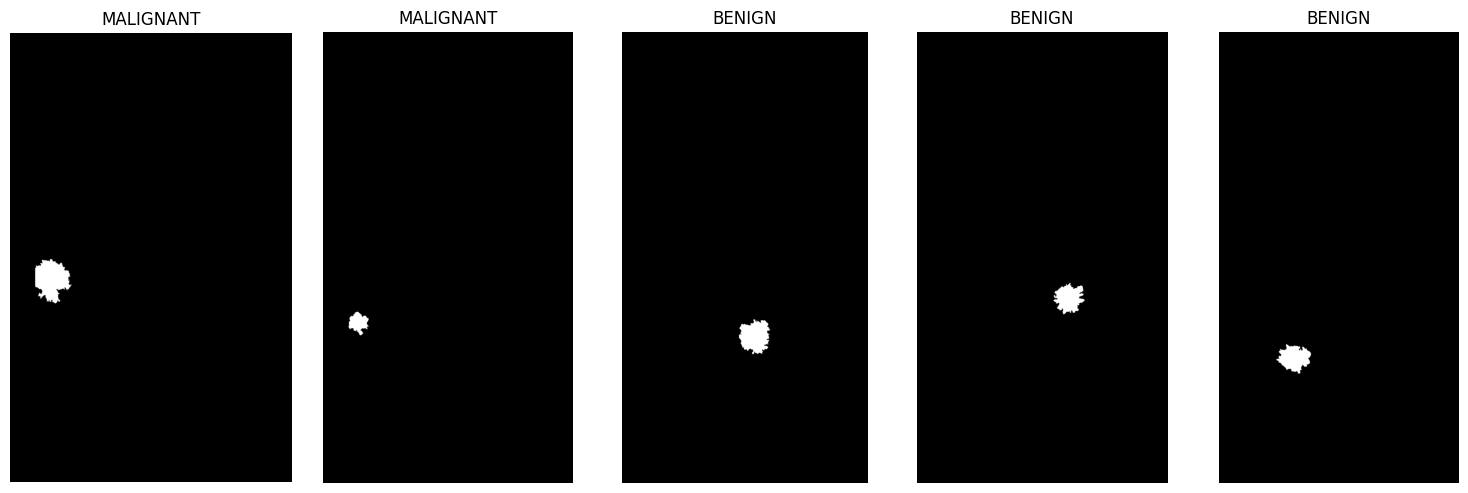

In [23]:
def display_images(column, number):
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    # Loop through rows and display images
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path', 5)
print('ROI mask:\n')
display_images('ROI_mask_file_path', 5)

In [24]:
print(mass_train.shape)

(1318, 14)


In [25]:
print(mass_test.shape)

(378, 14)


## PREPROCESSING****

In [26]:
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore")

In [27]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)
EPOCHS = 10

# Augmentation generator
aug = ImageDataGenerator(
    rotation_range=15,    # Rotate by 15 degrees
    zoom_range=0.1,       # Zoom by 10%
    horizontal_flip=True, # Flip horizontally
    fill_mode='nearest'   # Fill mode for edge pixels
)

In [28]:
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found at {image_path}")
    return image

# Function to preprocess a single image
def preprocess_image(image, target_size=TARGET_SIZE):
    image = cv2.resize(image, target_size)   # Resize
    image = image / 255.0                    # Normalize to [0, 1]
    image = np.stack([image]*3, axis=-1)     # Convert to 3-channel (grayscale to RGB)
    return preprocess_input(image)           # ResNet-specific preprocessing


In [29]:
def generate_mask(image, k=2):
    # Flatten the image for clustering
    pixel_values = image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixel_values)
    labels = kmeans.labels_.reshape(image.shape)
    
    # Choose the cluster with the highest average intensity (assuming it's the region of interest)
    mask = np.uint8(labels == labels.max()) * 255
    return mask

# Function to apply the mask to the image
def apply_mask(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image


In [30]:
def augment_image(image):
    # Expand dimensions for augmentation (ImageDataGenerator expects rank-4 arrays)
    image = np.expand_dims(image, axis=0)
    aug_image = next(aug.flow(image, batch_size=1))[0]  # Perform augmentation and return augmented image
    return aug_image

# Function to process a batch of images (MRI, Cropped, ROI)
def preprocess_and_augment_images(df):
    images = []
    print("Starting image preprocessing and augmentation...")

    # Use tqdm to add a progress bar
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
        mri = load_image(row['image_file_path'])
        mask = generate_mask(mri)
        masked_mri = apply_mask(mri, mask)

        # Preprocess and augment
        mri = preprocess_image(masked_mri)
        mri_augments = [mri] + [augment_image(mri) for _ in range(3)]  # 4 augmentations
        images.extend(mri_augments)

    print("Image preprocessing and augmentation completed.")
    return np.array(images)

In [31]:
def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    return [early_stopping, checkpoint]


In [32]:
def process_all_images_in_batches(mass_train, batch_size=BATCH_SIZE):
    num_images = len(mass_train)
    num_batches = (num_images + batch_size - 1) // batch_size

    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, num_images)
        print(f"Processing batch {batch_idx + 1}/{num_batches}...")

        df_batch = mass_train.iloc[start_idx:end_idx]
        mri_batch = preprocess_and_augment_images_batch(df_batch)
        yield mri_batch, df_batch['pathology'].values

In [33]:
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def image_processor(image_path, target_size):
    """Preprocess images for CNN model"""
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = image / 255.0
    return image_array

# Merge datasets
full_mass = pd.concat([mass_train, mass_test], axis=0)

# Define the target size
target_size = (224, 224, 3)

# Apply preprocessor to train data
full_mass['processed_images'] = full_mass['image_file_path'].apply(lambda x: image_processor(x, target_size))

# Create a binary mapper
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 

# Convert the processed_images column to an array
X_resized = np.array(full_mass['processed_images'].tolist())

# Apply class mapper to pathology column
full_mass['labels'] = full_mass['pathology'].replace(class_mapper)

# Check the number of classes
num_classes = len(full_mass['labels'].unique())

# Split data into train, test, and validation sets (70, 20, 10)
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, full_mass['labels'].values, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Convert integer labels to one-hot encoded labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [34]:
full_mass.head()

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                             cropped_image_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                                  ROI_mask_file_path  \
0  ../input/cbis-ddsm-breast-cancer-image-dataset...   
1  ../input/cbis-ddsm-breast-cancer-image-dataset...   
2  ../input/cbis-ddsm-breast-cancer-image-dataset...   
3  ../input/cbis-ddsm-breast-cancer-image-dataset...   
4  ../input/cbis-ddsm-breast-cancer-image-dataset...   

                                    processed_images  labels  
0  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...       1  
1  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...       1  
2  [[[0.9490196078431372, 0.9490196078431372, 0.9...       0  
3  [[[0.7450980392156863, 0.7450980392156863, 0.7...       0  
4  [[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...       0

**##FLOW##**

In [35]:
print(X_train.shape)
print(y_train.shape)

(1187, 224, 224, 3)
(1187, 2)


In [36]:
# Import necessary TensorFlow libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Augment data
train_datagen = ImageDataGenerator(rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest'
                                  )

# Apply augmentation to training data
train_data_augmented = train_datagen.flow(X_train, y_train, batch_size=16)






In [37]:

# Instantiate CNN model
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  # Flatten feature maps
model.add(Dense(512, activation='relu'))  # Add fully connected layers
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

# Train model with callbacks
history = model.fit(train_data_augmented, 
                    epochs=20, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping, model_checkpoint]
                   )

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 894ms/step - accuracy: 0.4920 - loss: 0.6937 - val_accuracy: 0.5179 - val_loss: 0.6982
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 879ms/step - accuracy: 0.5512 - loss: 0.6908 - val_accuracy: 0.5179 - val_loss: 0.6932
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 880ms/step - accuracy: 0.5572 - loss: 0.6891 - val_accuracy: 0.5179 - val_loss: 0.6944
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 879ms/step - accuracy: 0.5501 - loss: 0.6845 - val_accuracy: 0.5357 - val_loss: 0.6890
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 68s 883ms/step - accuracy: 0.5413 - loss: 0.6903 - val_accuracy: 0.5298 - val_loss: 0.6972
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 865ms/step - accuracy: 0.5203 - loss: 0.6893 - val_accuracy: 0.5298 - val_loss: 0.6912
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 878ms/step - accuracy: 0.5424 - loss: 0.6813 - val_accuracy: 0.5179 - val_loss: 0.6914


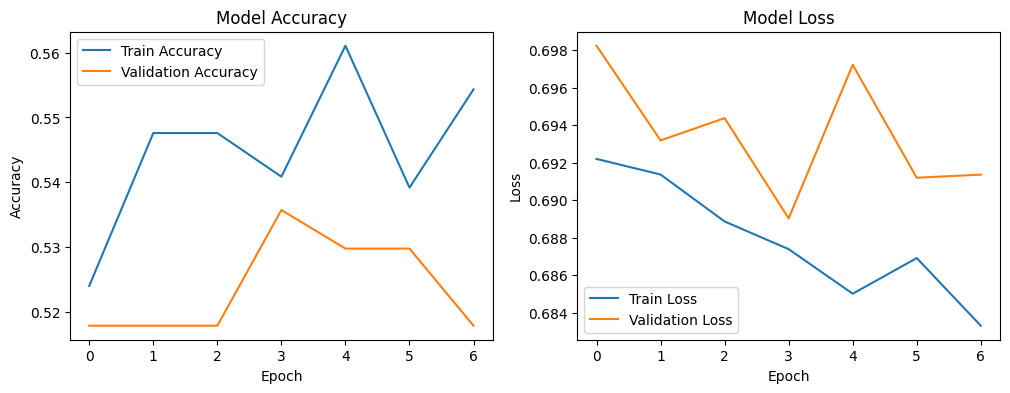

In [38]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [39]:
model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 450ms/step - accuracy: 0.5325 - loss: 0.6886


[0.688810408115387, 0.5278592109680176]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step
Train Set Classification report:
               precision    recall  f1-score   support

   MALIGNANT       0.55      0.98      0.70       650
      BENIGN       0.40      0.01      0.03       537

    accuracy                           0.54      1187
   macro avg       0.47      0.50      0.37      1187
weighted avg       0.48      0.54      0.40      1187




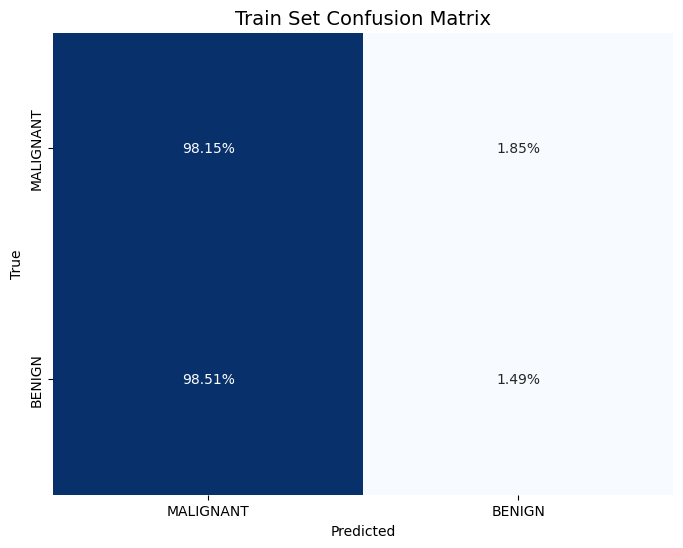

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

# create labels for confusion matrix
cm_labels = ['MALIGNANT', 'BENIGN']

# obtain predictions
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# convert predicted probabilities to class predictions
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_train = np.argmax(y_pred_train, axis=1)

# Assuming y_test and y_val are in binary format (0 or 1)
y_true_classes_test = np.argmax(y_test, axis=1)
y_true_classes_train = np.argmax(y_train, axis=1)

# generate classification reports for test and val sets
test_report = classification_report(y_true_classes_test, y_pred_classes_test, target_names=cm_labels)
train_report = classification_report(y_true_classes_train, y_pred_classes_train, target_names=cm_labels)

# generate confusion matrices for test and validation sets
test_cm = confusion_matrix(y_true_classes_test, y_pred_classes_test)
train_cm = confusion_matrix(y_true_classes_train, y_pred_classes_train)

# create function to print confusion matrix
def plot_confusion_matrix(cm, labels, title):
    """plots a normalized confusion matrix as a heatmap."""
    # Calculate row sums
    row_sums = cm.sum(axis=1, keepdims=True)
    # Normalize confusion matrix
    normalized_cm = cm / row_sums

    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# print Train and Test reports and matrices
print(f"Train Set Classification report:\n {train_report}\n")
plot_confusion_matrix(train_cm, cm_labels, 'Train Set Confusion Matrix')

In [41]:
from sklearn.cluster import KMeans
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

In [42]:
def create_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Add classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)  # Binary classification for pathology

    # Define the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Print the layers of the base model
    for i, layer in enumerate(base_model.layers):
        print(f"Layer {i}: {layer.name} ")

    # Compile the model for the first phase (training the new layers)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [43]:
model = create_model()
#callbacks = get_callbacks()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Layer 0: input_layer_1 
Layer 1: zero_padding2d 
Layer 2: conv1_conv 
Layer 3: conv1_bn 
Layer 4: conv1_relu 
Layer 5: zero_padding2d_1 
Layer 6: pool1 
Layer 7: conv2_block1_0_bn 
Layer 8: conv2_block1_0_relu 
Layer 9: conv2_block1_1_conv 
Layer 10: conv2_block1_1_bn 
Layer 11: conv2_block1_1_relu 
Layer 12: conv2_block1_2_conv 
Layer 13: conv2_block1_concat 
Layer 14: conv2_block2_0_bn 
Layer 15: conv2_block2_0_relu 
Layer 16: conv2_block2_1_conv 
Layer 17: conv2_block2_1_bn 
Layer 18: conv2_block2_1_relu 
Layer 19: conv2_block2_2_conv 
Layer 20: conv2_block2_concat 
Layer 21: conv2_block3_0_bn 
Layer 22: conv2_block3_0_relu 
Layer 23: conv2_block3_1_conv 
Layer 24: conv2_block3_1_bn 
Layer 25: conv2_block3_1_relu 
Layer 26: conv2_block3_2_conv 
Layer 27: conv2_block3_concat 
Layer 28: conv2_block4_0_bn 
Layer 29: conv2_block4_0_relu 
Layer 30: conv2_block4_1_conv 
Layer 31: conv2_block4_1_bn 
Layer 32: conv2_block4_1_relu 
Layer 33:

In [44]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,089,154 (30.86 MB)

 Trainable params: 1,051,650 (4.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [45]:
history = model.fit(
    train_data_augmented,  # Use the augmented labels
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint],
    verbose=1
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5245 - loss: 1.0004 - val_accuracy: 0.5774 - val_loss: 0.7419
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6085 - loss: 0.7027 - val_accuracy: 0.6369 - val_loss: 0.6595
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.5774 - loss: 0.6856 - val_accuracy: 0.6369 - val_loss: 0.6488
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.5932 - loss: 0.6577 - val_accuracy: 0.6369 - val_loss: 0.6383
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.6417 - loss: 0.6441 - val_accuracy: 0.6607 - val_loss: 0.6417
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.6481 - loss: 0.6307 - val_accuracy: 0.6369 - val_loss: 0.6304
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.6199 - loss: 0.6444 - val_accuracy: 0.6071 - val_loss: 0.6698
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.6493 - loss: 0.6363 - val_accuracy: 0.6310 - v

In [46]:
def fine_tune_model(model):
    # Get the base model from the original model
     # This gets the DenseNet121 part of your model

    # Unfreeze the last 20 layers of the base model for fine-tuning
    for layer in model.layers[403:424]:
        layer.trainable = True

    # Re-compile the model for fine-tuning with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
fine_tune_model(model)

In [48]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,089,154 (30.86 MB)

 Trainable params: 1,537,410 (5.86 MB)

 Non-trainable params: 6,551,744 (24.99 MB)

In [49]:
history_finetune = model.fit(
    train_data_augmented,  # Use the augmented labels
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint],
    verbose=1
    )
    
    

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.6401 - loss: 0.6226 - val_accuracy: 0.6667 - val_loss: 0.6149
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6725 - loss: 0.6124 - val_accuracy: 0.6786 - val_loss: 0.6093
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6786 - loss: 0.6021 - val_accuracy: 0.6726 - val_loss: 0.6076
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6701 - loss: 0.6054 - val_accuracy: 0.6845 - val_loss: 0.6045
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6320 - loss: 0.6290 - val_accuracy: 0.6667 - val_loss: 0.6065
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6529 - loss: 0.6128 - val_accuracy: 0.6667 - val_loss: 0.6036
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6827 - loss: 0.5914 - val_accuracy: 0.6667 - val_loss: 0.6044
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6866 - loss: 0.6011 - val_accuracy: 0.6845 - v

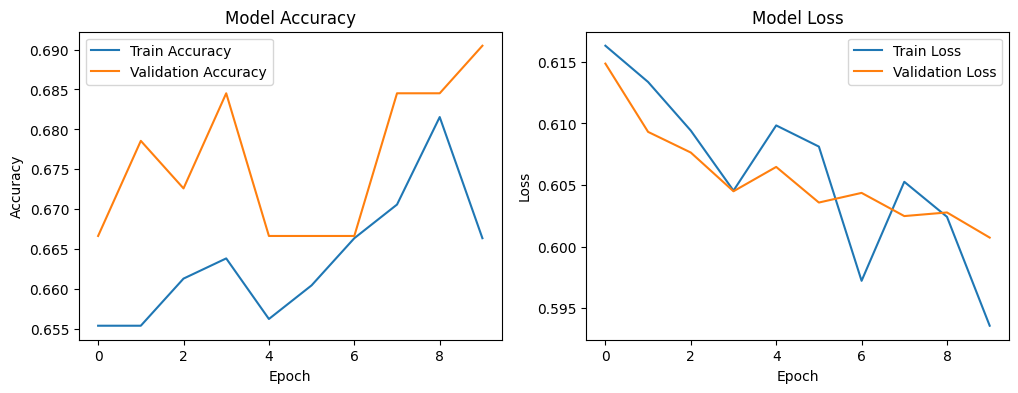

In [50]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [51]:
model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.6688 - loss: 0.5877


[0.6013513207435608, 0.6598240733146667]

11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step
Train Set Classification report:
               precision    recall  f1-score   support

   MALIGNANT       0.69      0.72      0.71       650
      BENIGN       0.64      0.61      0.63       537

    accuracy                           0.67      1187
   macro avg       0.67      0.67      0.67      1187
weighted avg       0.67      0.67      0.67      1187




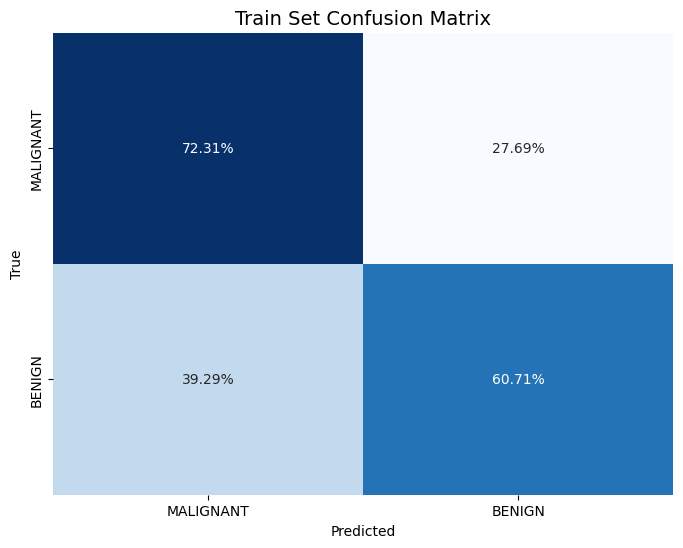

test Set Classification report:
               precision    recall  f1-score   support

   MALIGNANT       0.67      0.67      0.67       175
      BENIGN       0.65      0.64      0.65       166

    accuracy                           0.66       341
   macro avg       0.66      0.66      0.66       341
weighted avg       0.66      0.66      0.66       341




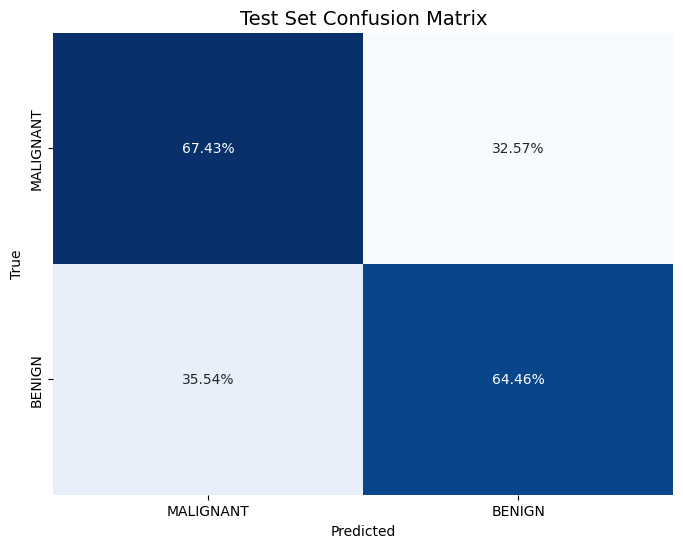

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

# create labels for confusion matrix
cm_labels = ['MALIGNANT', 'BENIGN']

# obtain predictions
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# convert predicted probabilities to class predictions
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_train = np.argmax(y_pred_train, axis=1)

# Assuming y_test and y_val are in binary format (0 or 1)
y_true_classes_test = np.argmax(y_test, axis=1)
y_true_classes_train = np.argmax(y_train, axis=1)

# generate classification reports for test and val sets
test_report = classification_report(y_true_classes_test, y_pred_classes_test, target_names=cm_labels)
train_report = classification_report(y_true_classes_train, y_pred_classes_train, target_names=cm_labels)

# generate confusion matrices for test and validation sets
test_cm = confusion_matrix(y_true_classes_test, y_pred_classes_test)
train_cm = confusion_matrix(y_true_classes_train, y_pred_classes_train)

# create function to print confusion matrix
def plot_confusion_matrix(cm, labels, title):
    """plots a normalized confusion matrix as a heatmap."""
    # Calculate row sums
    row_sums = cm.sum(axis=1, keepdims=True)
    # Normalize confusion matrix
    normalized_cm = cm / row_sums

    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# print Train and Test reports and matrices
print(f"Train Set Classification report:\n {train_report}\n")
plot_confusion_matrix(train_cm, cm_labels, 'Train Set Confusion Matrix')
print(f"test Set Classification report:\n {test_report}\n")
plot_confusion_matrix(test_cm, cm_labels, 'Test Set Confusion Matrix')

In [53]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np

# Load ResNet50 without the final fully connected layers (include_top=False)
resnet_base = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Add Global Average Pooling layer to flatten the feature maps
x = resnet_base.output
x = GlobalAveragePooling2D()(x)

# Define the model that outputs the extracted features
feature_extractor = Model(inputs=resnet_base.input, outputs=x)

# Print summary to check the architecture
feature_extractor.summary()

# Load and preprocess your dataset (X_train, y_train)
# Assuming X_train is the MRI images

# Extract features for the training set



Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [54]:
X_train_features = feature_extractor.predict(X_train)

38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step


In [55]:
X_val_features = feature_extractor.predict(X_val)

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [56]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assume X_train_features and X_val_features have been previously defined

# Standardize the extracted features before training SVM
scaler = StandardScaler()

# Fit the scaler only on the training features
X_train_features_scaled = scaler.fit_transform(X_train_features)

# Transform the validation features using the same scaler
X_val_features_scaled = scaler.transform(X_val_features)

# Convert one-hot encoded labels to single-label format
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Train SVM on the extracted features
svm_model = SVC(kernel='linear')  # You can try other kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_features_scaled, y_train_labels)

# Predict on validation set
y_pred = svm_model.predict(X_val_features_scaled)

# Evaluate the model
accuracy = accuracy_score(y_val_labels, y_pred)
print(f"Validation Accuracy for linear kernel: {accuracy * 100:.2f}%")


Validation Accuracy for linear kernel: 60.12%


In [57]:
svm_model = SVC(kernel='poly')  # You can try other kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_features_scaled, y_train_labels)

# Predict on validation set
y_pred = svm_model.predict(X_val_features_scaled)

# Evaluate the model
accuracy = accuracy_score(y_val_labels, y_pred)
print(f"Validation Accuracy for poly: {accuracy * 100:.2f}%")


Validation Accuracy for poly: 61.31%


In [58]:
svm_model = SVC(kernel='rbf')  # You can try other kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train_features_scaled, y_train_labels)

# Predict on validation set
y_pred = svm_model.predict(X_val_features_scaled)

# Evaluate the model
accuracy = accuracy_score(y_val_labels, y_pred)
print(f"Validation Accuracy for rbf: {accuracy * 100:.2f}%")


Validation Accuracy for rbf: 61.90%


In [59]:

from sklearn.metrics import accuracy_score, classification_report

In [60]:
def extract_features(model, data):
    # Make predictions to extract features
    features = model.predict(data)
    return features

X_test_features = extract_features(feature_extractor, X_test)
X_test_features_scaled = scaler.transform(X_test_features)

11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step


In [61]:
y_test_labels = np.argmax(y_test, axis=1)
y_test_pred = svm_model.predict(X_test_features_scaled)

# Step 8: Evaluate the model on test set
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print("Test Classification Report for kernel = linear:")
print(classification_report(y_test_labels, y_test_pred))

Test Accuracy: 62.76%
Test Classification Report for kernel = linear:
              precision    recall  f1-score   support

           0       0.60      0.80      0.69       175
           1       0.68      0.45      0.54       166

    accuracy                           0.63       341
   macro avg       0.64      0.62      0.61       341
weighted avg       0.64      0.63      0.62       341



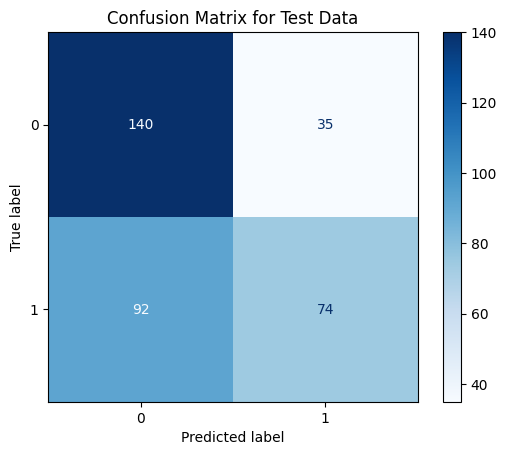

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_test_pred)

# Step 2: Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test_labels))

# Step 3: Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Data')
plt.show()